#### 各パッケージのインストール，データ，hyperparametersの読み込み

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 1 µs, sys: 4 µs, total: 5 µs
Wall time: 5.96 µs


In [2]:
# CSVファイルにデータを保存
filename_with_force = 'rossler_data_with_force1.3.1.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P']].values

print(X)


[[ 1.          1.          0.        ]
 [ 0.8143561   1.11164722  0.00998374]
 [ 0.64878658  1.20790655  0.01986771]
 ...
 [-4.88427402  7.01678759  0.03264432]
 [-5.56651533  6.63051689  0.02304443]
 [-6.2071844   6.16955935  0.01321426]]


In [3]:
hyperopt_config = {
    "exp": f"hyperopt-rossler_with_force1.3.1", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [5]:
import json

# JSONファイルから最適なハイパーパラメータを読み込む
with open(f"{hyperopt_config['exp']}_best_params.json", 'r') as f:
    best_params_loaded = json.load(f)

# 読み込んだパラメータを使用する
# 例えば、新しいモデルを設定するなど


FileNotFoundError: [Errno 2] No such file or directory: 'hyperopt-rossler_with_force1.3.1_best_params.json'

In [277]:
best_params_loaded


{'N': 4477.0,
 'iss': 0.0847552772285739,
 'lr': 0.4589596869564032,
 'ridge': 4.843985123099407e-09,
 'seed': 0,
 'sr': 0.8361142665850508}

### 7. Generative Modelのうち，外力のデータのみ実データで更新し続ける．

期待としては，X, Yの精度も上がるということである．

In [19]:
n,m = X.shape

from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))


In [24]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [25]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout


In [57]:
N = 10000
iss = 0.08487429516603366
lr = 0.6613014945020316
ridge = 6.3862820679702745e-09
seed = 5555
sr = 1.133073443655351
forecast = 1
train_len = 10000
seed_timesteps = 5000
nb_generations = 2000


In [58]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

esn = esn.fit(X_train, y_train)


/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.49807e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


In [59]:
X_test.shape


(15099, 3)

In [60]:
warming_inputs = X_test[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．


[ 6.15421081 -3.72998768 -0.09987137]:warming_out[-1]
[ 6.1542054  -3.72998775 -0.09987136]:X_test[seed_timesteps]


In [61]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [62]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]


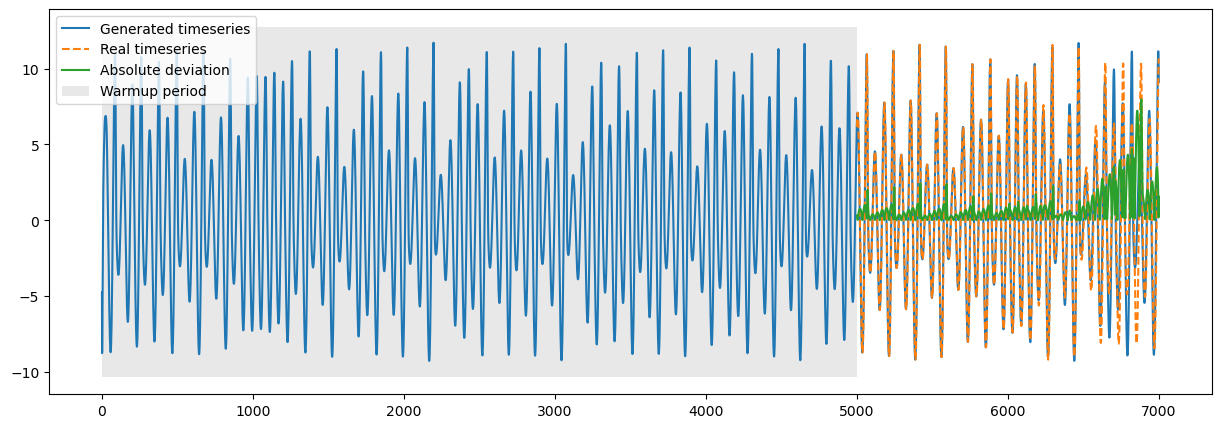

In [63]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)


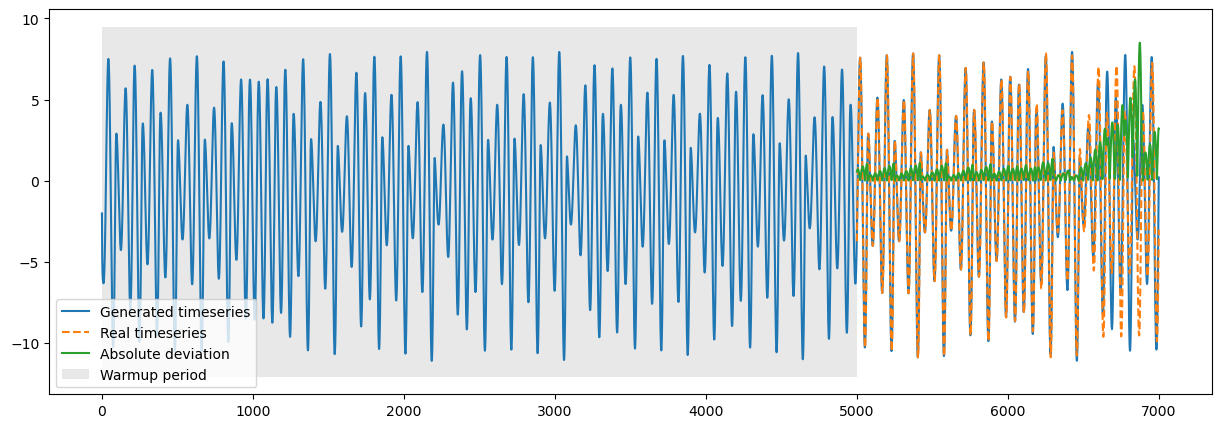

In [64]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


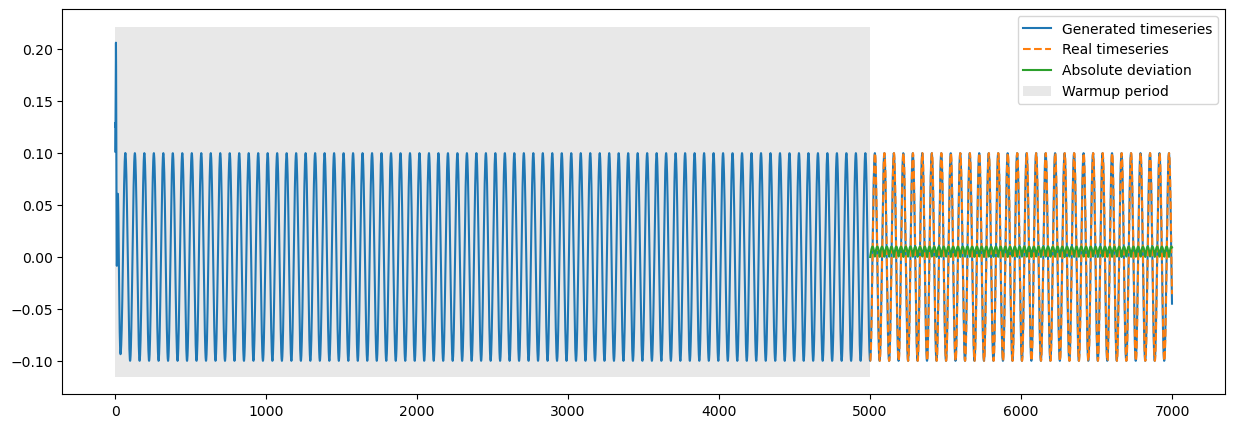

In [65]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


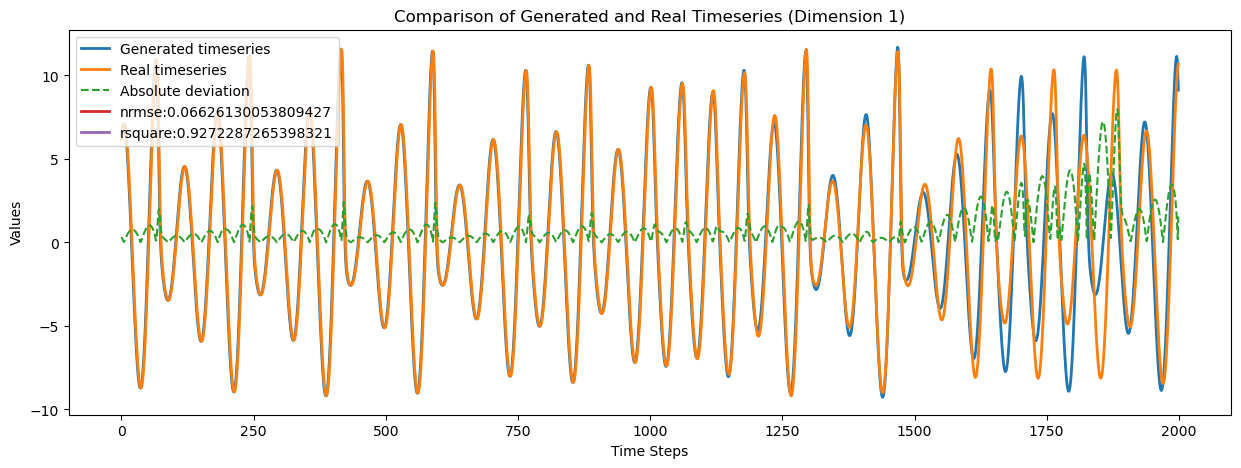

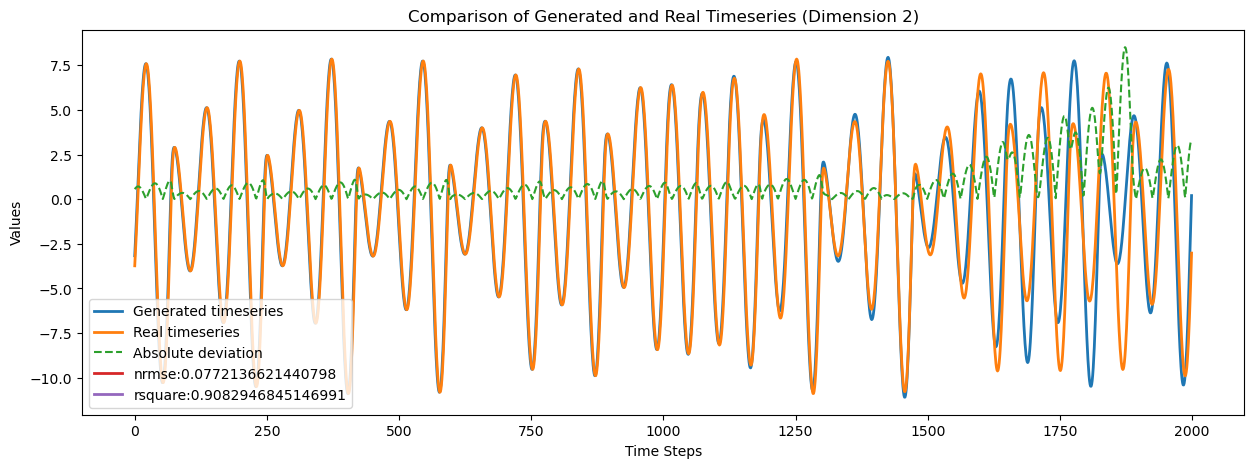

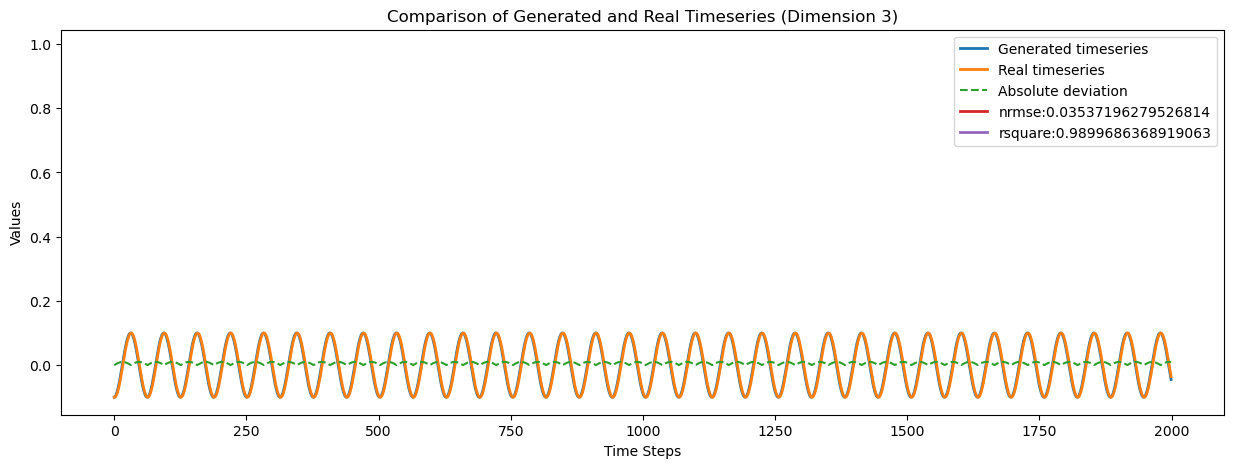

In [66]:
# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim] - X_gen[:, dim]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim], X_t[:, dim]), label=f"nrmse:{nrmse(X_gen[:, dim], X_t[:, dim])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim], X_t[:, dim]), label=f"rsquare:{rsquare(X_gen[:, dim], X_t[:, dim])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()

# 使用例:
compare_timeseries_multidimensional(X_gen, X_t)


25期先までの予測．